In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
from glob import glob
import os
from matplotlib.colors import ListedColormap
from stdatamodels.jwst import datamodels as dm
from BNBG.Pipeline.BetterBackgroundSubtractStep import getDataWithMask, cleanupImage
from BNBG.utils import getSourcePosition
from matplotlib.patches import Rectangle
import matplotlib.patheffects as path_effects

In [6]:
class MultiStepObject:
	def __init__(self, folder):
		"""
		Acts as a container for MOS data at Stage 2 (cals), Stage 2 + BNBG (BNBG) and backgrounds (bkg), and Stage 3 (s2d).

		Parameters
		----------
		folder : str
			Path to the folder
		"""
		def get_sorted_files(folder, pattern):
			files = glob(os.path.join(folder, pattern))
			files.sort()
			return files

		cal_list = get_sorted_files(folder, '*nrs1_cal.fits') + get_sorted_files(folder, '*nrs2_cal.fits')
		print(cal_list)
		s2d2_list = get_sorted_files(folder, '*nrs1_s2d.fits') + get_sorted_files(folder, '*nrs2_s2d.fits')
		bkg_list = get_sorted_files(folder, '*nrs1_bkg-BNBG.fits') + get_sorted_files(folder, '*nrs2_bkg-BNBG.fits')
		BNBG_list = get_sorted_files(folder, '*nrs1_cal-BNBG.fits') + get_sorted_files(folder, '*nrs2_cal-BNBG.fits')

		# Assuming lists are of format
		# [001_nrs1, 002_nrs1, 003_nrs1, 001_nrs2, 002_nrs2, 003_nrs2]

		s2d_list = glob(os.path.join(folder, 'Final/*_s2d.fits'))
		print("Opening CALs")
		self.cal_list = [fits.open(_) for _ in cal_list]

		# list of lists, each containing an HDU representing wavelengths from cal
		self.wavelength_list = [[_ for _ in cal if _.name == "WAVELENGTH"] for cal in self.cal_list]

		# list of lists, each containing an HDU representing data from cal
		self.cal_list = [[_ for _ in cal if _.name == "SCI"] for cal in self.cal_list]

		# list of lists, each containing the source id of every slit
		# TODO : some duplicate sources, need to find another way to discriminate between slits
		self.cal_sources = [[_.header["sourceid"] for _ in cal] for cal in self.cal_list]

		print("Opening S2D2S")
		# list of Datamodels for each s2d from stage 2, dm.slits acts the same as a list of lists
		self.s2d2_list = [dm.open(_) for _ in s2d2_list]

		print("Opening BKGs")
		# list of lists, each containing an HDU representing the bkg of each cal
		self.bkg_list = [fits.open(_) for _ in bkg_list]
		self.bkg_list = [[_ for _ in bkg if _.name == "SCI"] for bkg in self.bkg_list]

		print("Opening BNBGs")
		# list of lists, each containing an HDU representing the background subtracted cal
		self.BNBG_list = [fits.open(_) for _ in BNBG_list]
		self.BNBG_list = [[_ for _ in BNBG if _.name == "SCI"] for BNBG in self.BNBG_list]

		print("Opening S2Ds")
		# list of s2d HDU from stage 3
		self.s2d_list = [fits.open(_) for _ in s2d_list]

		# list of corresponding source ids
		self.s2d_sources = [s2d[1].header["sourceid"] for s2d in self.s2d_list]

		print("Updating Context")
		#self._update_context()

	def plot(self, directory):
		"""
		Iterates on every source and saves the plot for each.

		Parameters
		----------
		directory : str
			Path to the folder where the plots will be saved
		"""
		for source_id in self.s2d_sources:
			cal_list = self._get_hdus_by_source(source_id, self.cal_list)
			bkg_list = self._get_hdus_by_source(source_id, self.bkg_list)
			bnbg_list = self._get_hdus_by_source(source_id, self.BNBG_list)
			wave_list = self._get_hdus_by_source(source_id, self.wavelength_list)
			s2d_list = MultiStepObject._get_slit_by_source(source_id, self.s2d2_list)
			s2d = self.s2d_list[self.s2d_sources.index(source_id)]

			isnrs1 = not all(_ is None for _ in cal_list[:3])
			isnrs2 = not all(_ is None for _ in cal_list[3:])

			if isnrs1:
				fig = MultiStepObject._plot(cal_list[:3], bkg_list[:3], bnbg_list[:3], wave_list[:3], s2d_list[:3], s2d)
				fig.savefig(f"{directory}/{source_id}-nrs1.png")
				plt.show()
			if isnrs2:
				fig = MultiStepObject._plot(cal_list[3:], bkg_list[3:], bnbg_list[3:], wave_list[3:], s2d_list[3:], s2d)
				fig.savefig(f"{directory}/{source_id}-nrs2.png")
				plt.show()

	def _update_context(self):
		"""
		The CON image within the s2d of stage 3 is defined relatively to the images used, and not absolutely to all the files used.
		This updates the CON image to be absolute.

		"""
		# For convenience, the cal files used in this class are organized as such
		# [nrs1-001, nrs1-002, nrs1-003, nrs2-001, nrs2-002, nrs2-003]
		# However, in the spec3 association file, they are organized like this :
		# [nrs1-001, nrs2-001, nrs1-002, nrs2-002, nrs1-003, nrs2-003]
		# The following array allows to map back to the spec3 order
		to_spec3_order = np.array([0, 3, 1, 4, 2, 5])
		for hdu in self.s2d_list:
			# Get a list of either None or an HDU if it exists for a given source id
			# Map it back to the spec3 order
			cal_list = np.array(self._get_hdus_by_source(hdu[1].header["sourceid"], self.cal_list))[to_spec3_order]

			# list of indices in cal_list where an HDU exists
			# This thus creates a map from the relative file order to the absolute
			relative_to_absolute = np.array([i for i in range(len(cal_list)) if not cal_list[i] is None])

			# Making a base 2 vector
			basis = 2**np.arange(6)
			basis = np.append(basis[relative_to_absolute],np.zeros(6)) # Since we don't care about indices for which no HDU exists, we append 6x0
			basis = basis[:6] # Remove the surplus of 0s
			basis = np.array(basis[::-1], dtype=np.int8) # Reverse the vector, since the least significant bit is on the right

			# Context image
			con = hdu["CON"].data[0,:,:]

			# Array of values of context defined relatively
			start = np.unique(con.ravel())

			# Convert those values to binary vectors
			end = np.array([np.array(list(f"{_:06b}"),dtype=np.int8) for _ in start], dtype=np.int8)
			end = np.array([_ @ basis for _ in end], dtype=np.int8)	# Multiply each vector by the new basis to get the new value

			# Updates the values of CON
			mp = np.arange(0,np.max(con)+1)
			mp[start] = end
			hdu["CON"].data[0,:,:] = mp[con]

	def _get_hdus_by_source(self, source_id, data_list):
		"""
		For a given source_id, will return a list the size of each list of lists of HDU,
		with None if no HDU corresponds to source_id within the file, or the first HDU found if there is.

		Parameters
		----------
		source_id : int
			The id of the source

		data_list :
			A list of lists of HDUs. Some HDUs may correpond to the same source_id, only the first one will be returned

		Returns
		-------
		result : list
			A list of length len(data_list), with each element being either an HDU or None
		"""
		# Hdus, sids are lists, one for each 00N_nrsM file (N=1,2,3, M=1,2)
		# Next will return the first element of all hdu that verify sid = source_id
		# If none is found, returns None
		return [
			next((hdu for hdu, sid in zip(hdus, sids) if sid == source_id), None)
			for hdus, sids in zip(data_list, self.cal_sources)
		]

	@staticmethod
	def _get_slit_by_source(source_id, slits_list):
		"""
		For a given source_id, will return a list the size of slits_list,
		with None if no slit corresponds to source_id within the slits, or the first slit found if there is.

		Parameters
		----------
		source_id : int
			The id of the source

		slits_list :
			A list of MultiSlitModels. Some slits may correpond to the same source_id, only the first one will be returned

		Returns
		-------
		result : list
			A list of length len(slits_list), with each element being either a slit or None
		"""
		return [next((slit for slit in multi_slit_model.slits if slit.source_id == source_id), None) for multi_slit_model in slits_list]

	@staticmethod
	def _binary_to_colormap(use_first_group=True):
		"""
		Create a colormap for 6-bit binary values based on additive color mixing.

		Parameters
		----------
		use_first_group : boolean
			If True, use bits 0,2,4; if False, use bits 1,3,5

		Returns
		-------

		"""
		colors = []
		for i in range(64):  # Iterate over all possible 6-bit values
			binary_str = f"{i:06b}"  # Convert number to 6-bit binary string
			if use_first_group:
				r, g, b = int(binary_str[0]), int(binary_str[2]), int(binary_str[4])
			else:
				r, g, b = int(binary_str[1]), int(binary_str[3]), int(binary_str[5])
			colors.append((r, g, b))  # Additive color mixing

		return ListedColormap(colors)

	@staticmethod
	def _plot(cal: list, bkg: list, bnbg: list, wave : list, s2d2: list, s2d):
		"""
		Creates a plot for a given sourceid and nrs.

		Parameters
		----------
		cal : list
			Should be of length 3, the cal HDUs corresponding to source_id

		bkg : list
			Should be of length 3, the bkg HDUs corresponding to source_id

		bnbg : list
			Should be of length 3, the background subtracted cals HDUs corresponding to source_id

		wave : list
			Should be of length 3, the wavelength HDUs corresponding to source_id

		s2d2 : list
			Should be of length 3, the s2d datamodels slits corresponding to source_id

		s2d : HDU
			A single HDU corresponding to the stage 3 s2d file for source_id

		Returns
		-------
		fig : matplotlib.figure.Figure
			The figure containing the plot

		"""
		# Get information from cal on source_id and nrs
		nrs = [_ for _ in s2d2 if not _ is None][0].meta.instrument.detector
		sourceid = [_ for _ in cal if not _ is None][0].header["SOURCEID"]
		cmap = NRS2_CMAP if nrs == "NRS2" else NRS1_CMAP

		# Create figure grid
		fig = plt.figure(figsize=(16, 12))
		gs = fig.add_gridspec(6, 4, height_ratios=[4, 4, 1.5, 1.5, 1.5, 12], hspace=0, wspace=0)

		# Block of 4x3 plots
		ax_s2d2 = [fig.add_subplot(gs[i+2, 0], xticks=[], yticks=[]) for i in range(3)]
		ax_cal = [fig.add_subplot(gs[i+2, 1], xticks=[], yticks=[]) for i in range(3)]
		ax_bkg = [fig.add_subplot(gs[i+2, 2], xticks=[], yticks=[]) for i in range(3)]
		ax_bnbg = [fig.add_subplot(gs[i+2, 3], xticks=[], yticks=[]) for i in range(3)]

		# 1 long bottom plot for the extracted background
		ax_spec = fig.add_subplot(gs[5, :])

		# 1 long top plot for the final stage 3 s2d
		ax_s2d = fig.add_subplot(gs[1, :], xticks=[], yticks=[])
		# The corresponding CON plot
		ax_con = fig.add_subplot(gs[0, :], xticks=[], yticks=[])

		def plot_cal(axs, imgs, masked=False):

			# Define same scale for every axs
			values = np.array([])
			for i in range(3):
				if imgs[i] is not None:
					values = np.append(values, imgs[i].data.ravel())
			values = values[np.isfinite(values)]
			z1, z2 = (0, 1) if len(values) == 0 else ZScaleInterval().get_limits(values)

			# Plot 3 nods
			for i in range(3):
				if imgs[i] is not None:
					# Can be called either if imgs is a list of HDUs or of slits
					img = imgs[i].data.copy()
					if not masked:
						axs[i].imshow(img, interpolation="none", origin="lower", vmin=z1, vmax=z2, aspect="auto", zorder=0)
					else :
						# If mask=True, will calculate a mask and plot the image twice, once in black and white,
						# and a second time in color and on top but with masked pixels
						axs[i].imshow(img, interpolation="none", origin="lower", vmin=z1, vmax=z2, aspect="auto", zorder=0, cmap="gray")

						# It is assumed here that imgs is a list of slits
						source = getSourcePosition(imgs[i])
						mask = cleanupImage(img,imgs[i].err.copy(),source=source)
						img[mask] = np.nan

						axs[i].imshow(img, interpolation="none", origin="lower", vmin=z1, vmax=z2, aspect="auto", zorder=1)


		plot_cal(ax_cal, cal)
		plot_cal(ax_bkg, bkg)
		plot_cal(ax_bnbg, bnbg)
		plot_cal(ax_s2d2, s2d2, masked=True)

		for ax, c, i in zip(ax_s2d2, ["g", "b", "r"], range(1,4)):
			ax.add_patch(Rectangle((0, 0), 4, 1, transform=ax.transAxes, color=c, alpha=0.3, zorder=-1, clip_on=False))
			text = ax.text(0.1, 0.3, f"00{i}", color="w", transform=ax.transAxes)
			text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()])

		z1, z2 = 1e10, -1e10
		for i, c in enumerate([np.array([0,1,0,1]), np.array([0,0,1,1]), np.array([1,0,0,1])]):
			if s2d2[i] is not None:
				# Data
				Y, X = np.indices(s2d2[i].data.shape)
				_, _, dataLambda = s2d2[i].meta.wcs.transform("detector", "world", X, Y)
				x,y,dy = getDataWithMask(s2d2[i].data.copy(), s2d2[i].err.copy(), dataLambda.copy(), source=getSourcePosition(s2d2[i]))
				if x is None or len(x) == 0:
					continue
				ax_spec.scatter(x, y, color=c, marker='+', alpha=0.6, label=f"00{i+1}")
				z1 = min(np.nanmin(y),z1)
				z2 = max(np.nanmax(y),z2)

				# Fit
				X = wave[i].data.ravel()
				Y = bkg[i].data.ravel()
				mask = (np.isfinite(X)) & (np.isfinite(Y))
				X, Y = X[mask], Y[mask]
				indices = np.argsort(X)
				X, Y = X[indices], Y[indices]

				color = np.clip(c+np.array([0.5, 0.5, 0.5, 1]), 0, 1)
				ax_spec.plot(X, Y, color=color)

		ax_spec.set_ylabel("Flux")
		ax_spec.set_xlabel(fr"$\lambda$ (µm)")

		# Hard coding the y limits to prevent the fit from scaling them
		dz = (z2 - z1) / 2
		z = (z1 + z2) / 2
		ax_spec.set_ylim(z-dz*1.05,z+dz*1.05)
		ax_spec.grid(True)
		ax_spec.legend()

		# Stage 3 s2d of source
		s2d_sci = s2d["SCI"].data
		z1, z2 = ZScaleInterval().get_limits(s2d_sci)
		ax_s2d.imshow(s2d_sci, interpolation="none", origin="lower", vmin=z1, vmax=z2, aspect="auto")

		# Context image for stage 3 s2d
		con_img = s2d["CON"].data[0, :, :].copy()
		ax_con.imshow(con_img, interpolation="none", origin="lower", cmap=cmap, vmin=0, vmax=63, aspect="auto")
		ax_con.set_title(f"{sourceid}-{nrs}")

		print(np.unique(con_img))

		for ax in ax_s2d2 + ax_cal + ax_bkg + ax_bnbg + [ax_s2d] + [ax_con]:
			ax.set_axis_off()

		return fig

NRS2_CMAP = MultiStepObject._binary_to_colormap(use_first_group=False)
NRS1_CMAP = MultiStepObject._binary_to_colormap(use_first_group=True)

In [4]:
MSO = MultiStepObject("/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/BNBG-n0.1/")

['/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/BNBG-n0.1/jw01345063001_03101_00001_nrs1_cal.fits', '/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/BNBG-n0.1/jw01345063001_03101_00002_nrs1_cal.fits', '/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/BNBG-n0.1/jw01345063001_03101_00003_nrs1_cal.fits', '/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/BNBG-n0.1/jw01345063001_03101_00001_nrs2_cal.fits', '/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/BNBG-n0.1/jw01345063001_03101_00002_nrs2_cal.fits', '/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/BNBG-n0.1/jw01345063001_03101_00003_nrs2_cal.fits']
Opening CALs
Opening S2D2S
Opening BKGs

In [ ]:
%matplotlib inline
plt.close("all")
MSO.plot("/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/SlitAnalysis")

['********' '********' '********' '********' '********' 'nrs1-001']
     ↓          ↓          ↓          ↓          ↓          ↓     
['********' '********' '********' '********' '********' 'nrs1-001']
00 - □□□□□□ → 00 - □□□□□□
01 - □□□□□■ → 01 - □□□□□■




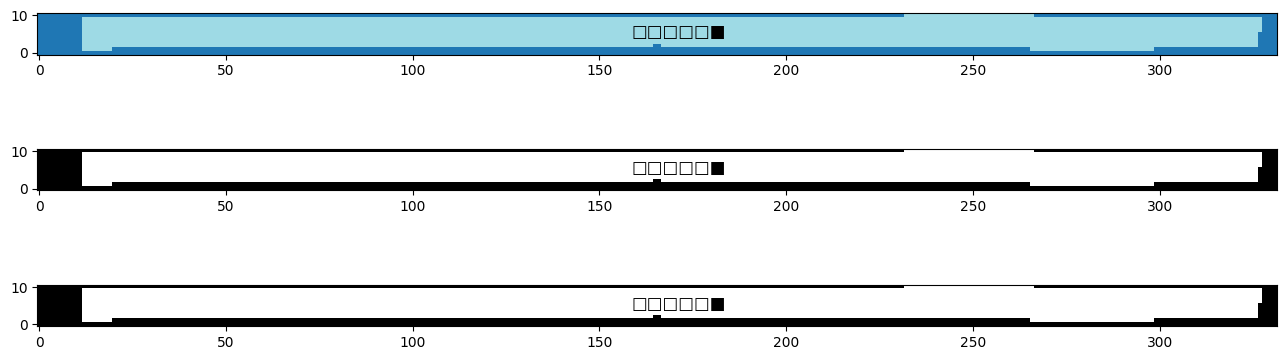

['********' '********' '********' 'nrs1-003' 'nrs1-002' 'nrs1-001']
     ↓          ↓          ↓          ↓          ↓          ↓     
['********' 'nrs1-003' '********' 'nrs1-002' '********' 'nrs1-001']
00 - □□□□□□ → 00 - □□□□□□
01 - □□□□□■ → 01 - □□□□□■
02 - □□□□■□ → 04 - □□□■□□
03 - □□□□■■ → 05 - □□□■□■
04 - □□□■□□ → 16 - □■□□□□
05 - □□□■□■ → 17 - □■□□□■
06 - □□□■■□ → 20 - □■□■□□
07 - □□□■■■ → 21 - □■□■□■




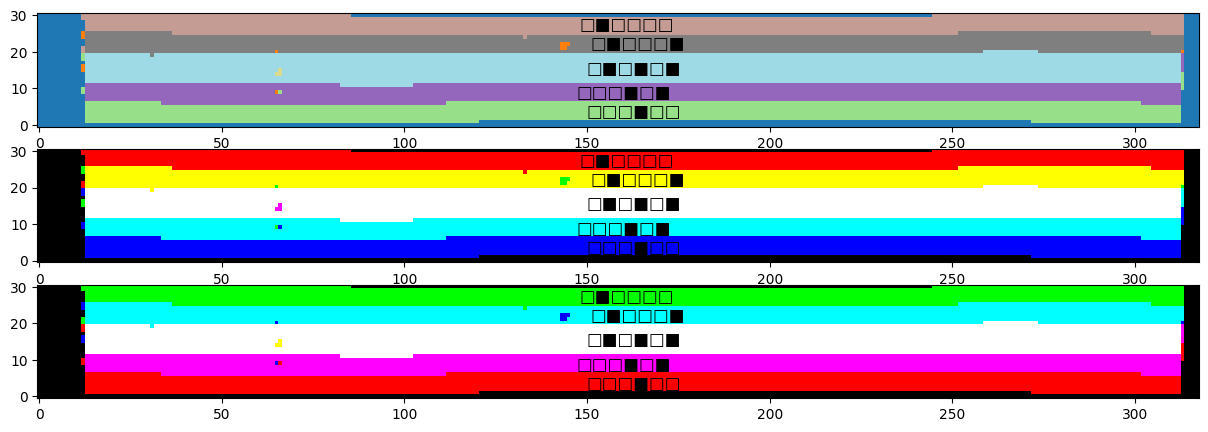

['********' '********' '********' 'nrs1-003' 'nrs1-002' 'nrs1-001']
     ↓          ↓          ↓          ↓          ↓          ↓     
['********' 'nrs1-003' '********' 'nrs1-002' '********' 'nrs1-001']
00 - □□□□□□ → 00 - □□□□□□
01 - □□□□□■ → 01 - □□□□□■
02 - □□□□■□ → 04 - □□□■□□
03 - □□□□■■ → 05 - □□□■□■
04 - □□□■□□ → 16 - □■□□□□
05 - □□□■□■ → 17 - □■□□□■
06 - □□□■■□ → 20 - □■□■□□
07 - □□□■■■ → 21 - □■□■□■




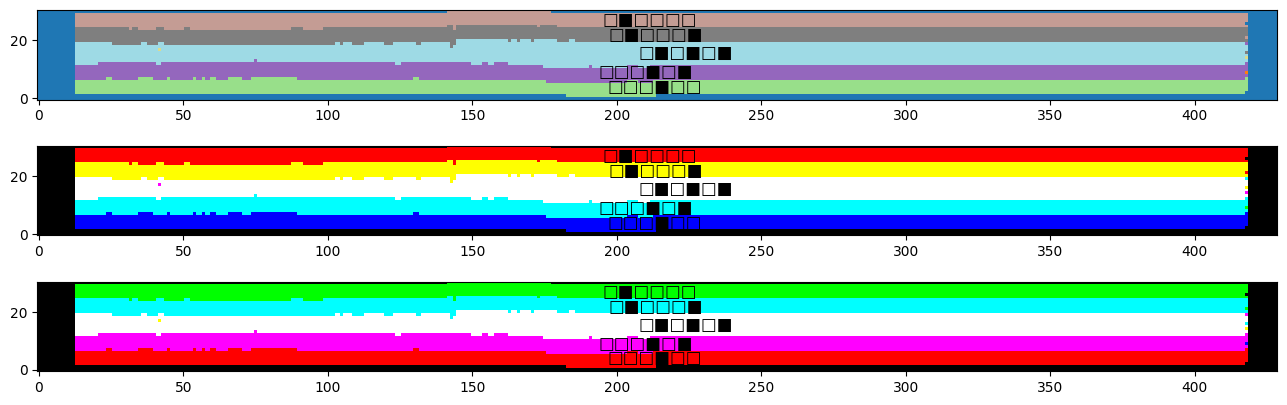

['********' '********' 'nrs2-001' '********' '********' '********']
     ↓          ↓          ↓          ↓          ↓          ↓     
['********' '********' '********' '********' 'nrs2-001' '********']
00 - □□□□□□ → 00 - □□□□□□
01 - □□□□□■ → 02 - □□□□■□




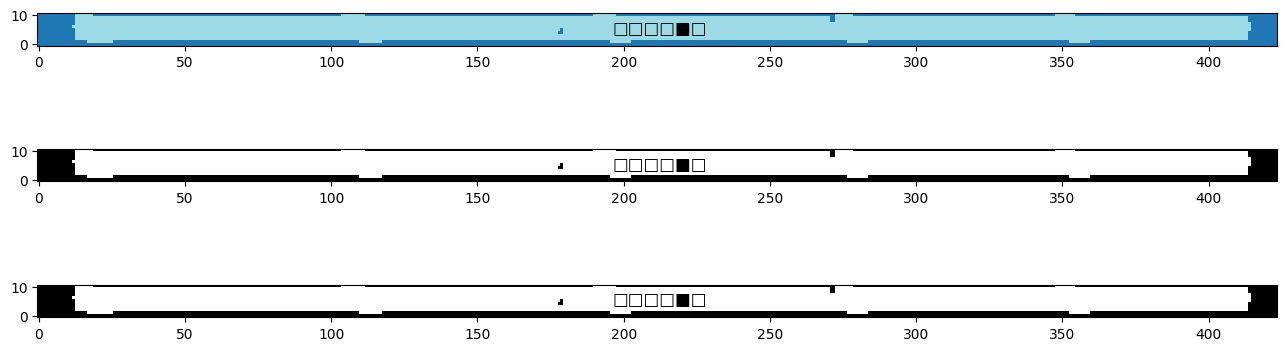

['********' 'nrs2-002' 'nrs2-001' '********' '********' '********']
     ↓          ↓          ↓          ↓          ↓          ↓     
['********' '********' 'nrs2-002' '********' 'nrs2-001' '********']
00 - □□□□□□ → 00 - □□□□□□
01 - □□□□□■ → 02 - □□□□■□
02 - □□□□■□ → 08 - □□■□□□
03 - □□□□■■ → 10 - □□■□■□




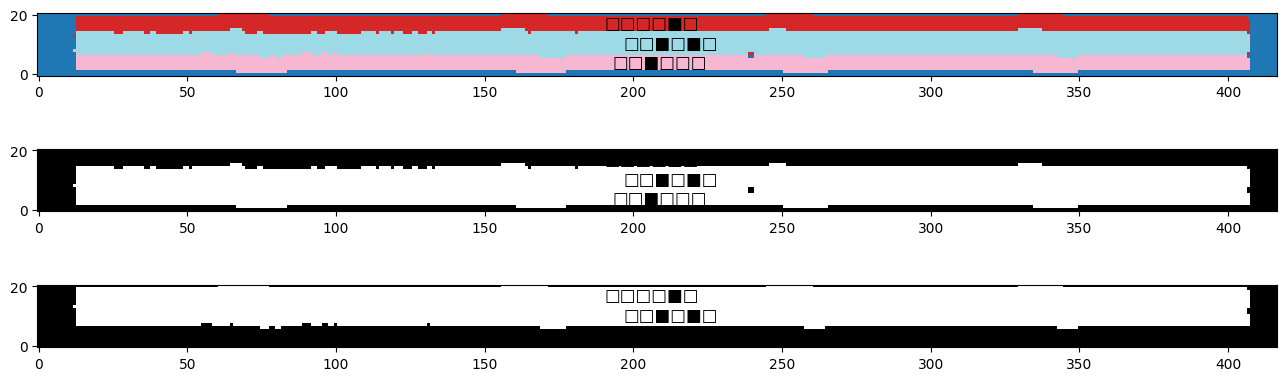

['nrs2-003' 'nrs2-002' 'nrs2-001' '********' '********' '********']
     ↓          ↓          ↓          ↓          ↓          ↓     
['nrs2-003' '********' 'nrs2-002' '********' 'nrs2-001' '********']
00 - □□□□□□ → 00 - □□□□□□
01 - □□□□□■ → 02 - □□□□■□
02 - □□□□■□ → 08 - □□■□□□
03 - □□□□■■ → 10 - □□■□■□
04 - □□□■□□ → 32 - ■□□□□□
05 - □□□■□■ → 34 - ■□□□■□
06 - □□□■■□ → 40 - ■□■□□□
07 - □□□■■■ → 42 - ■□■□■□




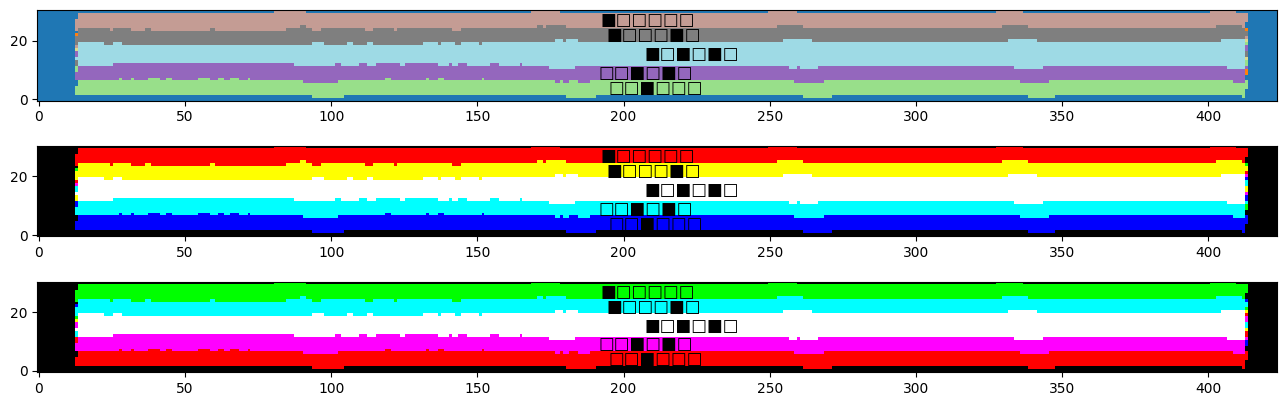

['********' '********' 'nrs2-001' '********' '********' 'nrs1-001']
     ↓          ↓          ↓          ↓          ↓          ↓     
['********' '********' '********' '********' 'nrs2-001' 'nrs1-001']
00 - □□□□□□ → 00 - □□□□□□
01 - □□□□□■ → 01 - □□□□□■
02 - □□□□■□ → 02 - □□□□■□




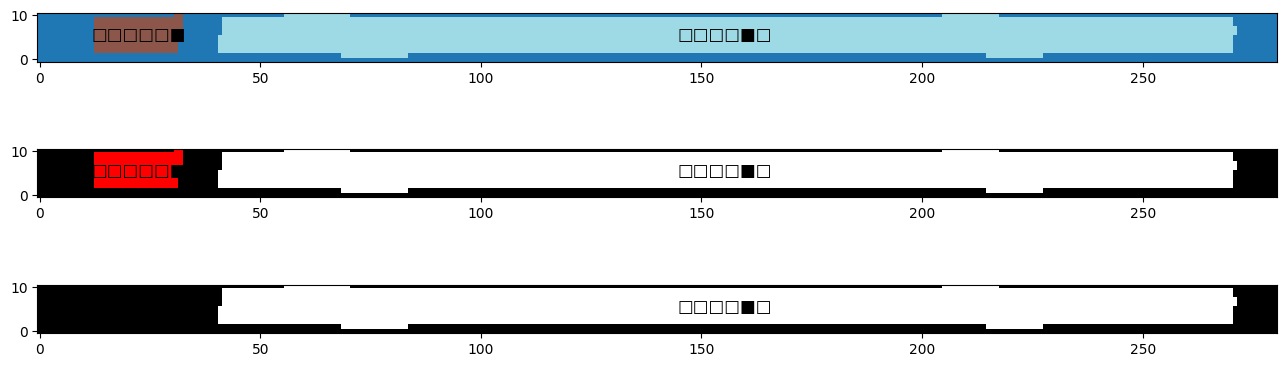

['********' 'nrs2-002' 'nrs2-001' '********' 'nrs1-002' 'nrs1-001']
     ↓          ↓          ↓          ↓          ↓          ↓     
['********' '********' 'nrs2-002' 'nrs1-002' 'nrs2-001' 'nrs1-001']
00 - □□□□□□ → 00 - □□□□□□
01 - □□□□□■ → 01 - □□□□□■
02 - □□□□■□ → 02 - □□□□■□
04 - □□□■□□ → 04 - □□□■□□
05 - □□□■□■ → 05 - □□□■□■
08 - □□■□□□ → 08 - □□■□□□
10 - □□■□■□ → 10 - □□■□■□




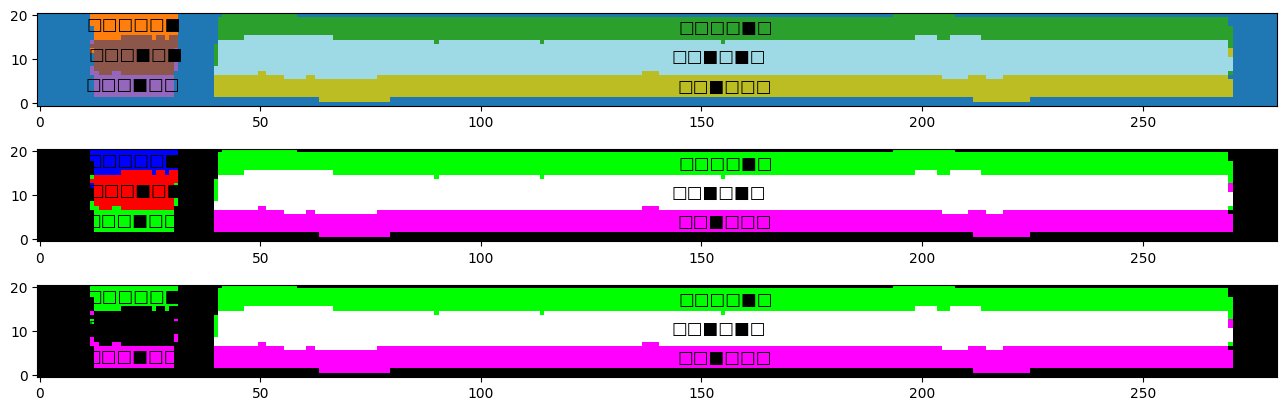

['nrs2-003' 'nrs2-002' 'nrs2-001' 'nrs1-003' 'nrs1-002' 'nrs1-001']
     ↓          ↓          ↓          ↓          ↓          ↓     
['nrs2-003' 'nrs1-003' 'nrs2-002' 'nrs1-002' 'nrs2-001' 'nrs1-001']
00 - □□□□□□ → 00 - □□□□□□
01 - □□□□□■ → 01 - □□□□□■
02 - □□□□■□ → 02 - □□□□■□
04 - □□□■□□ → 04 - □□□■□□
05 - □□□■□■ → 05 - □□□■□■
08 - □□■□□□ → 08 - □□■□□□
10 - □□■□■□ → 10 - □□■□■□
16 - □■□□□□ → 16 - □■□□□□
17 - □■□□□■ → 17 - □■□□□■
21 - □■□■□■ → 21 - □■□■□■
32 - ■□□□□□ → 32 - ■□□□□□
34 - ■□□□■□ → 34 - ■□□□■□
42 - ■□■□■□ → 42 - ■□■□■□




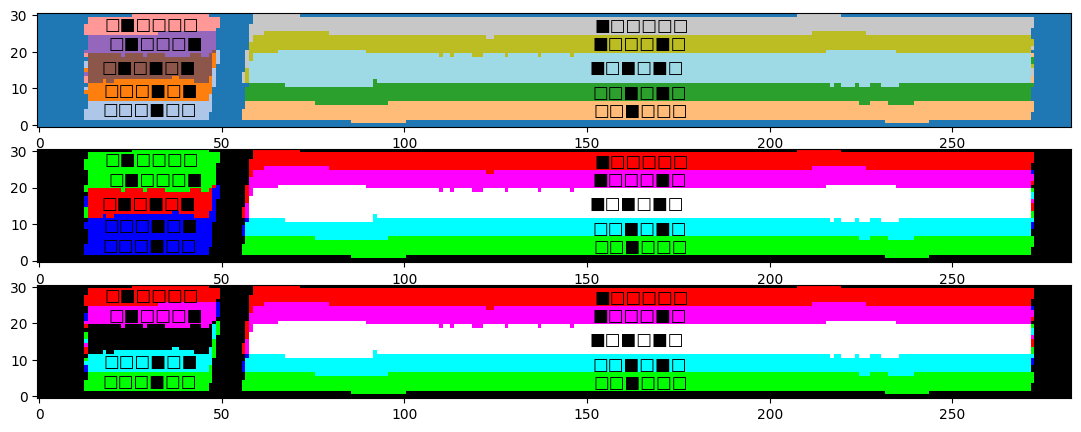

In [8]:
import scipy.ndimage

%matplotlib inline

plt.close("all")

sources = [-90, -86, -85, -4, -16, -1, -61, -64, -62]

names = ["nrs1-001", "nrs1-002", "nrs1-003", "nrs2-001", "nrs2-002", "nrs2-003"]
to_spec3_order = np.array([0, 3, 1, 4, 2, 5])

for source_id in sources:

	cal_list = MSO._get_hdus_by_source(source_id, MSO.cal_list)
	bkg_list = MSO._get_hdus_by_source(source_id, MSO.bkg_list)
	bnbg_list = MSO._get_hdus_by_source(source_id, MSO.BNBG_list)
	wave_list = MSO._get_hdus_by_source(source_id, MSO.wavelength_list)
	s2d_list = MultiStepObject._get_slit_by_source(source_id, MSO.s2d2_list)
	s2d = MSO.s2d_list[MSO.s2d_sources.index(source_id)]

	isnrs1 = not all(_ is None for _ in cal_list[:3])
	isnrs2 = not all(_ is None for _ in cal_list[3:])

	con = np.unique(s2d["CON"].data[0, :, :])

	exists = np.array(["********" if cal_list[i] is None else names[i] for i in range(6)])
	print(exists[::-1])
	print("".join(["     ↓     "]*6))
	exists = exists[to_spec3_order]
	print(exists[::-1])

	relative_to_absolute = np.array([i for i in range(len(exists)) if not exists[i] == "********"])

	# Making a base 2 vector
	basis = 2**np.arange(6)
	basis = np.append(basis[relative_to_absolute],np.zeros(6)) # Since we don't care about indices for which no HDU exists, we append 6x0
	basis = basis[:6] # Remove the surplus of 0s
	basis = np.array(basis[::-1], dtype=np.int8) # Reverse the vector, since the least significant bit is on the right

	# Array of values of context defined relatively
	start = con

	# Convert those values to binary vectors
	end = np.array([np.array(list(f"{_:06b}"),dtype=np.int8) for _ in start], dtype=np.int8)
	end = np.array([_ @ basis for _ in end], dtype=np.int8)	# Multiply each vector by the new basis to get the new value

	for k,_ in enumerate(con):
		pattern = "".join(['□' if j == '0' else '■' for j in list(f"{_:06b}")])
		new = end[k]
		new_pattern = "".join(['□' if j == '0' else '■' for j in list(f"{new:06b}")])
		print(f"{_:02} - {pattern} → {new:02} - {new_pattern}")
	print("\n")

	CON = np.array(s2d["CON"].data[0, :, :].copy(), dtype=np.int64)


	fig, ax = plt.subplots(3,1,figsize=(16,5))
	ax[0].imshow(CON, origin="lower", cmap="tab20", interpolation="none")
	ax[1].imshow(CON, origin="lower", cmap=NRS1_CMAP, interpolation="none")
	ax[2].imshow(CON, origin="lower", cmap=NRS2_CMAP, interpolation="none")


	text_positions = []
	# Process each unique value separately
	for k,value in enumerate(np.unique(CON)):
		if value == 0:
			continue
		new = end[k]
		pattern = "".join(['□' if j == '0' else '■' for j in list(f"{new:06b}")])
		mask = (CON == value)  # Binary mask for the current value
		labeled, num_features = scipy.ndimage.label(mask)  # Label connected components

		# Compute sizes of each zone
		sizes = np.bincount(labeled.ravel())[1:]  # Exclude background (label 0)

		# Find large zones
		large_zones = np.where(sizes >= 50)[0] + 1  # Labels start from 1

		# Compute centroids of large zones
		centroids = scipy.ndimage.center_of_mass(mask, labeled, index=large_zones)

		# Annotate large zones with their values
		for (y, x) in centroids:
			for _ in ax:
				_.text(x, y, pattern, color='k', ha='center', va='center',
					 fontsize=12, fontweight='bold')

	plt.show()


In [9]:
for i, c in enumerate(NRS1_CMAP.colors):
	pattern = "".join(['□' if j == '0' else '■' for j in list(f"{i:06b}")])
	print(f"{i:02} - {pattern} - {c} / {NRS2_CMAP.colors[i]}")

00 - □□□□□□ - (0, 0, 0) / (0, 0, 0)
01 - □□□□□■ - (0, 0, 0) / (0, 0, 1)
02 - □□□□■□ - (0, 0, 1) / (0, 0, 0)
03 - □□□□■■ - (0, 0, 1) / (0, 0, 1)
04 - □□□■□□ - (0, 0, 0) / (0, 1, 0)
05 - □□□■□■ - (0, 0, 0) / (0, 1, 1)
06 - □□□■■□ - (0, 0, 1) / (0, 1, 0)
07 - □□□■■■ - (0, 0, 1) / (0, 1, 1)
08 - □□■□□□ - (0, 1, 0) / (0, 0, 0)
09 - □□■□□■ - (0, 1, 0) / (0, 0, 1)
10 - □□■□■□ - (0, 1, 1) / (0, 0, 0)
11 - □□■□■■ - (0, 1, 1) / (0, 0, 1)
12 - □□■■□□ - (0, 1, 0) / (0, 1, 0)
13 - □□■■□■ - (0, 1, 0) / (0, 1, 1)
14 - □□■■■□ - (0, 1, 1) / (0, 1, 0)
15 - □□■■■■ - (0, 1, 1) / (0, 1, 1)
16 - □■□□□□ - (0, 0, 0) / (1, 0, 0)
17 - □■□□□■ - (0, 0, 0) / (1, 0, 1)
18 - □■□□■□ - (0, 0, 1) / (1, 0, 0)
19 - □■□□■■ - (0, 0, 1) / (1, 0, 1)
20 - □■□■□□ - (0, 0, 0) / (1, 1, 0)
21 - □■□■□■ - (0, 0, 0) / (1, 1, 1)
22 - □■□■■□ - (0, 0, 1) / (1, 1, 0)
23 - □■□■■■ - (0, 0, 1) / (1, 1, 1)
24 - □■■□□□ - (0, 1, 0) / (1, 0, 0)
25 - □■■□□■ - (0, 1, 0) / (1, 0, 1)
26 - □■■□■□ - (0, 1, 1) / (1, 0, 0)
27 - □■■□■■ - (0, 1, 1) / (1